In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime, timedelta

In [2]:
Punct_List = dict((ord(punct), None) for punct in string.punctuation + '¿¡')

def TxNormalize(text):
    
    return word_tokenize(text.lower().translate(Punct_List))

def respuesta(texto):
    Tokens_List.append(texto)
    TfidfVec = TfidfVectorizer(tokenizer = TxNormalize) 
    tfidf = TfidfVec.fit_transform(Tokens_List)
    Tokens_List.remove(texto)
    vals = cosine_similarity(tfidf[-1], tfidf)
    flat = vals.flatten()
    flat.sort()
    
    return Tokens_List[vals.argsort()[0][-2]]

# Datos Vacunación

In [3]:
url = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov/documentos/Informe_Comunicacion_'

for i in range(10):

    df = (pd.read_excel(url + (datetime.now() - timedelta(days = + i)).strftime("%Y%m%d") + '.ods', engine="odf")
          .set_index('Unnamed: 0'))
    
    if len(df) > 0:
        break

df.head()

,Dosis entregadas Pfizer (1),Dosis entregadas Moderna (1),Total Dosis entregadas (1),Dosis administradas (2),% sobre entregadas,Nº Personas vacunadas(pauta completada),Fecha de la última vacuna registrada (2)
Unnamed: 0,,,,,,,
Andalucía,400230,16600,416830,345648,0.829230,117953,2021-02-03
Aragón,68175,2900,71075,65979,0.928301,19535,2021-02-03
Asturias,69935,2900,72835,65301,0.896561,25710,2021-02-03
Baleares,35460,1500,36960,29366,0.794535,7929,2021-02-03
Canarias,79530,3200,82730,75334,0.910601,20260,2021-02-03


# Datos población

In [4]:
url = 'https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/2853.csv?nocab=1'

poblacion = pd.read_csv(url, error_bad_lines=False, sep=';', header=0)

poblacion = poblacion[(poblacion['Comunidades y Ciudades Autónomas'] != 'Total') 
                      & (poblacion['Periodo'] == 2020)].pivot(index = 'Comunidades y Ciudades Autónomas'
                                                             , columns = 'Sexo'
                                                             , values = 'Total')

Tokens_List = sent_tokenize(" ".join(review for review in df.index + '.'), 'spanish')
matriz = {}

for i in poblacion.index.values:
    matriz[i] = respuesta(i.replace('Balears','Baleares'))[:-1]
            
poblacion.index = poblacion.index.map(matriz)

poblacion.head()

Sexo,Hombres,Mujeres,Total
Comunidades y Ciudades Autónomas,,,
Andalucía,4.170.605,4.293.806,8.464.411
Aragón,656.056,673.335,1.329.391
Asturias,486.066,532.718,1.018.784
Baleares,584.298,587.245,1.171.543
Canarias,1.076.185,1.099.767,2.175.952


# Datos edad x comunidad

In [5]:
Url = 'https://www.ine.es/jaxi/files/_px/es/csv_bdsc/t20/e245/p08/l0/02003.csv_bdsc?nocab=1'

xx = pd.read_csv(Url, error_bad_lines=False, sep=';', header=0)

xx = xx[(xx['Españoles/Extranjeros']=='TOTAL')
        & (xx['Sexo']=='Ambos sexos')
        & (xx['Año']==2020)
        & (xx['Edad (año a año)']!='TOTAL EDADES')
        & (xx['Comunidades']!='TOTAL ESPAÑA')]

matriz = {}

for i in xx[(xx['Comunidades']!='TOTAL ESPAÑA')]['Comunidades'].unique():
    matriz[i] = respuesta(i.lower().replace('balears','baleares'))[:-1]

xx['Edad'] = (xx['Edad (año a año)']
              .str.replace(' años','')
              .str.replace(' año','')
              .str.replace(' y más','')
              .astype('int64', copy=False))

xx.Edad = xx.Edad.map(lambda x: 'Ancianos' if x >= 85 else 'Resto')
xx.Comunidades = xx.Comunidades.map(matriz)

xx.Total = pd.to_numeric(xx.Total.str.replace('.',''), errors='coerce')
xx = (pd.pivot_table(xx, index = 'Comunidades'
                    , columns= 'Edad'
                    , values = ['Total']
                    , aggfunc=[np.sum])
      .droplevel(0, axis=1)
      .droplevel(0, axis=1) 
     )

xx.Ancianos = xx.Ancianos / (xx.Ancianos + xx.Resto) * 100

xx.head()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Edad,Ancianos,Resto
Comunidades,,
Andalucía,2.493369,8253362.0
Aragón,4.349736,1271566.0
Asturias,5.022360,967617.0
Baleares,2.226039,1145464.0
C. Valenciana,2.852955,4913069.0


In [6]:
df = (df.merge(poblacion, left_index=True, right_index=True)
      .merge(xx['Ancianos'], left_index=True, right_index=True)
      .rename(columns = {'Dosis entregadas Pfizer (1)':'Dosis Pfizer'
         , 'Dosis entregadas Moderna (1)': 'Dosis Moderna'
         , 'Total Dosis entregadas (1)': 'Dosis'
         , 'Dosis administradas (2)': 'Puestas'
         , '% sobre entregadas': 'Usadas'
         , 'Nº Personas vacunadas(pauta completada)':'Inmunizados'
         , 'Fecha de la última vacuna registrada (2)':'Fecha_datos'
        }))

df['PrimeraDosis'] = df.Puestas - df.Inmunizados
df.Total = df.Total.str.replace('.','').astype('int64', copy=False)
df['Vac1'] = df.PrimeraDosis / df.Total * 100
df['Vac2'] = df.Inmunizados / df.Total * 100

df.sort_values(by='Vac1', ascending=False)
    
df.head()

,Dosis Pfizer,Dosis Moderna,Dosis,Puestas,Usadas,Inmunizados,Fecha_datos,Hombres,Mujeres,Total,Ancianos,PrimeraDosis,Vac1,Vac2
Andalucía,400230,16600,416830,345648,0.829230,117953,2021-02-03,4.170.605,4.293.806,8464411,2.493369,227695,2.690028,1.393517
Aragón,68175,2900,71075,65979,0.928301,19535,2021-02-03,656.056,673.335,1329391,4.349736,46444,3.493630,1.469470
Asturias,69935,2900,72835,65301,0.896561,25710,2021-02-03,486.066,532.718,1018784,5.022360,39591,3.886103,2.523597
Baleares,35460,1500,36960,29366,0.794535,7929,2021-02-03,584.298,587.245,1171543,2.226039,21437,1.829809,0.676800
Canarias,79530,3200,82730,75334,0.910601,20260,2021-02-03,1.076.185,1.099.767,2175952,2.097197,55074,2.531030,0.931087


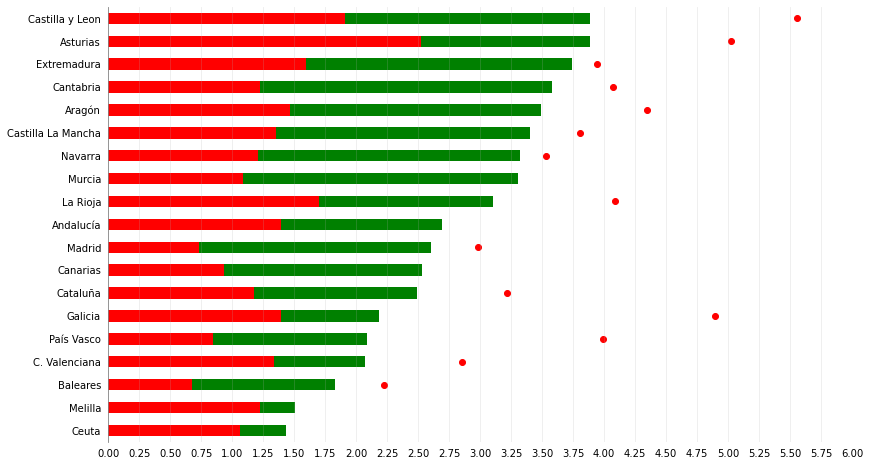

In [7]:
df.sort_values(by='Vac1', ascending=True, inplace = True)
df['vc'] = df.Vac1 - df.Vac2
df[['Vac2','vc']].plot(kind = 'barh'
                         , stacked = True
                       , legend = None
                       , color = ['red','green']
                       , figsize = (16 / 1.2, 8)
                        )

plt.scatter(df.Ancianos, df.index, color= 'red')
plt.grid(axis='x', alpha=0.25)

[spine.set_visible(False) for spine in plt.gca().spines.values()]
plt.gca().tick_params(left = False, bottom = False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['left'].set_color('grey')

vals = plt.gca().get_xticks()
vals = np.linspace(start = vals.min(), stop = vals.max(), num = len(vals) * 4 - 3)

plt.gca().set_xticks(vals)
plt.gca().set_xticklabels(['{:3.2f}'.format(x) for x in vals])

plt.show()